<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading 

**Chapter 05 &mdash; Predicting Market Movements with Machine Learning**

## Using Linear Regression for Market Movement Prediction

### A Quick Review of Linear Regression

In [2]:
import os
import random
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

/tmp/ipykernel_233775/987665674.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
x = np.linspace(0, 10)

In [4]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
set_seeds() # <4>

In [37]:
y = x + np.random.standard_normal(len(x))

In [38]:
reg = np.polyfit(x, y, deg=1)

In [39]:
reg

array([ 1.01541672, -0.06955588])

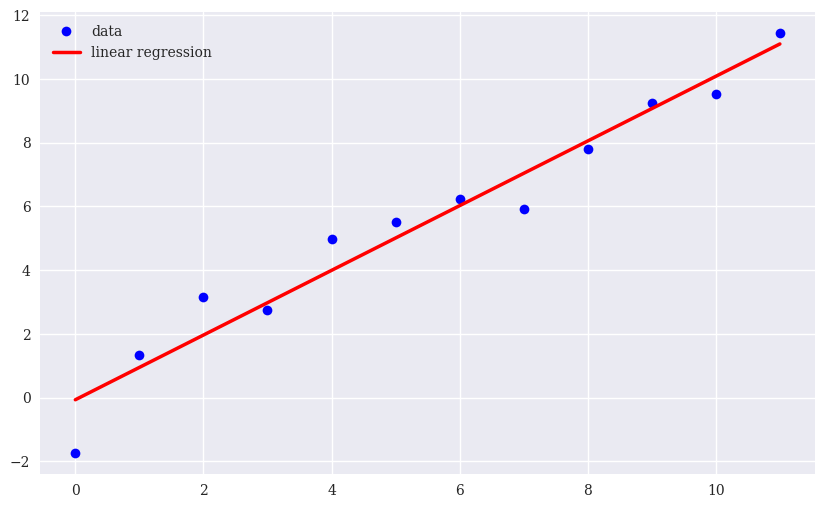

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='data')
plt.plot(x, np.polyval(reg, x), 'r', lw=2.5,
         label='linear regression')
plt.legend(loc=0);
# plt.savefig('../../images/ch05/lr_plot_1.png')

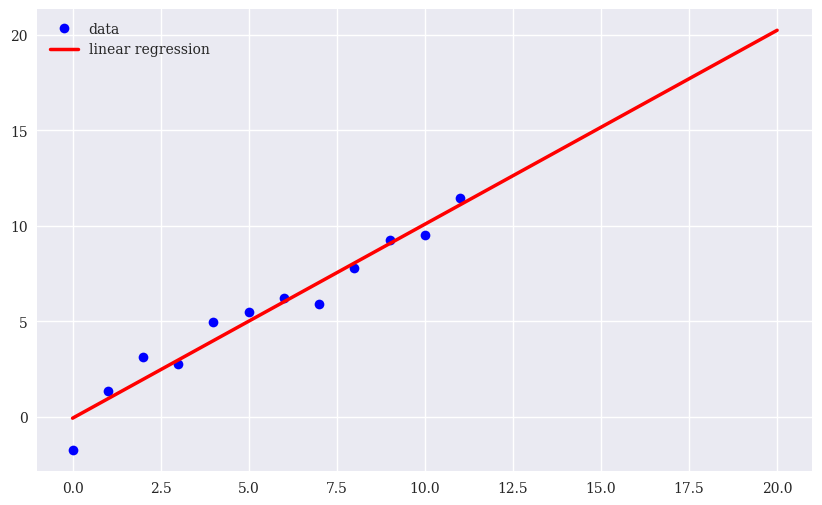

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='data')
xn = np.linspace(0, 20)
plt.plot(xn, np.polyval(reg, xn), 'r', lw=2.5,
         label='linear regression')
plt.legend(loc=0);
# plt.savefig('../../images/ch05/lr_plot_2.png')

### The Basic Idea for Price Prediction

In [42]:
x = np.arange(12)

In [43]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [44]:
lags = 3

In [45]:
m = np.zeros((lags + 1, len(x) - lags))

In [46]:
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]

In [47]:
m.T

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.],
       [ 3.,  4.,  5.,  6.],
       [ 4.,  5.,  6.,  7.],
       [ 5.,  6.,  7.,  8.],
       [ 6.,  7.,  8.,  9.],
       [ 7.,  8.,  9., 10.],
       [ 8.,  9., 10., 11.]])

In [48]:
reg = np.linalg.lstsq(m[:lags].T, m[lags], rcond=None)[0]

In [49]:
reg

array([-0.66666667,  0.33333333,  1.33333333])

In [50]:
np.dot(m[:lags].T, reg)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

### Predicting Index Levels

In [51]:
import pandas as pd

In [52]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [53]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [54]:
symbol = 'EUR='

In [55]:
data = pd.DataFrame(raw[symbol])

In [56]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [57]:
lags = 5

In [58]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['price'].shift(lag) # <1>
    cols.append(col)
data.dropna(inplace=True)

In [59]:
reg = np.linalg.lstsq(data[cols], data['price'],
                      rcond=None)[0]

In [60]:
reg

array([ 0.98635864,  0.02292172, -0.04769849,  0.05037365, -0.01208135])

In [61]:
data['prediction'] = np.dot(data[cols], reg)

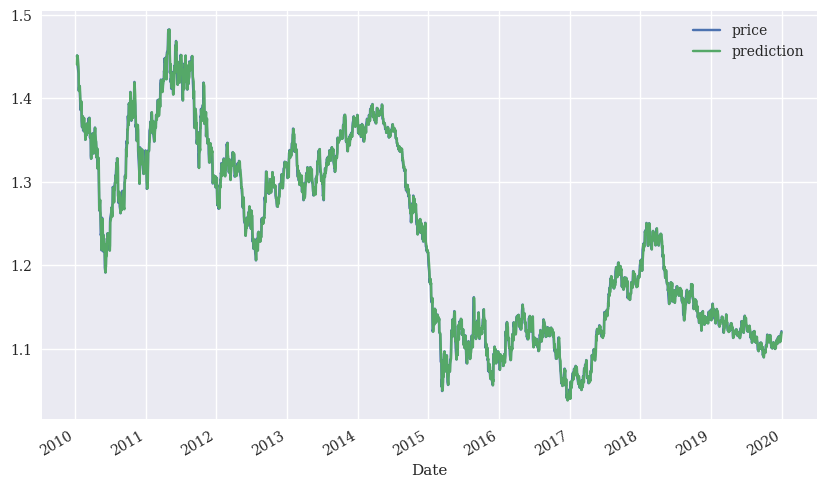

In [62]:
data[['price', 'prediction']].plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_3.png')

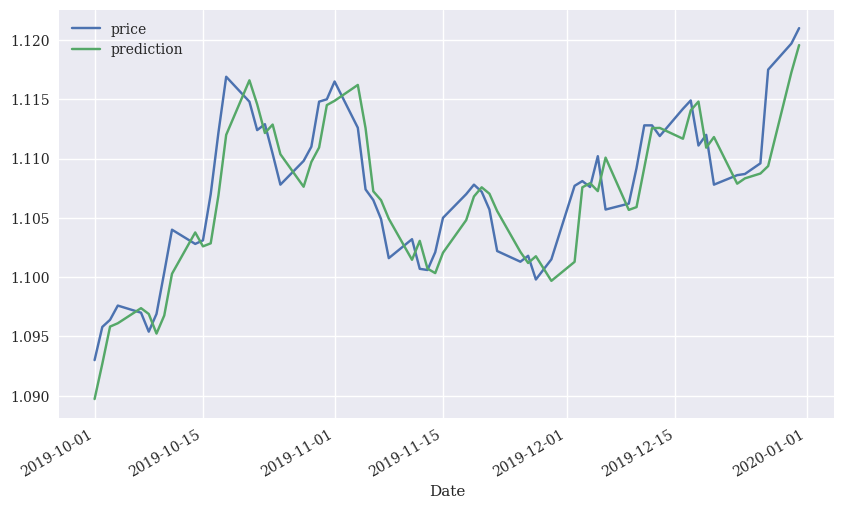

In [63]:
data[['price', 'prediction']].loc['2019-10-1':].plot(
            figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_4.png')

### Predicting Future Returns

In [64]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1))

In [65]:
data.dropna(inplace=True)

In [66]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <3>
    cols.append(col)
data.dropna(inplace=True)

In [67]:
reg = np.linalg.lstsq(data[cols], data['return'],
                      rcond=None)[0]

In [68]:
reg

array([-0.015689  ,  0.00890227, -0.03634858,  0.01290924, -0.00636023])

In [69]:
data['prediction'] = np.dot(data[cols], reg)

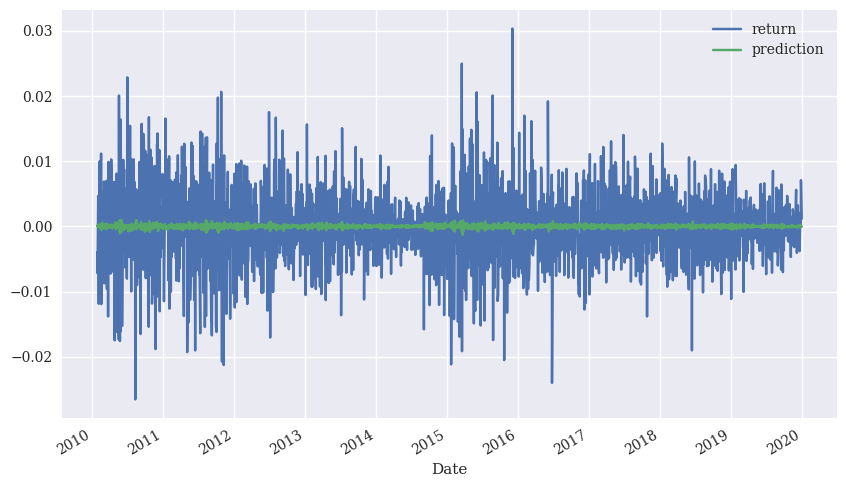

In [70]:
data[['return', 'prediction']].iloc[lags:].plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_5.png')

In [71]:
hits = np.sign(data['return'] *
               data['prediction']).value_counts()

In [72]:
hits

 1.0    1250
-1.0    1242
 0.0      13
dtype: int64

In [73]:
hits.values[0] / sum(hits)

0.499001996007984

### Prediction Future Market Direction

In [74]:
reg = np.linalg.lstsq(data[cols], np.sign(data['return']),
                      rcond=None)[0]

In [75]:
reg

array([-5.11938725, -2.24077248, -5.13080606, -3.03753232, -2.14819119])

In [76]:
data['prediction'] = np.sign(np.dot(data[cols], reg))

In [77]:
data['prediction'].value_counts()

 1.0    1300
-1.0    1205
Name: prediction, dtype: int64

In [78]:
hits = np.sign(data['return'] *
               data['prediction']).value_counts()

In [79]:
hits

 1.0    1301
-1.0    1191
 0.0      13
dtype: int64

In [80]:
hits.values[0] / sum(hits)

0.5193612774451097

### Vectorized Backtesting of Regression-based Strategy 

In [81]:
data.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,prediction,return
Date,,,,,,,,
2010-01-20,1.4101,-0.005858,-0.008309,-0.000551,0.001103,-0.001310,1.0,-0.013874
2010-01-21,1.4090,-0.013874,-0.005858,-0.008309,-0.000551,0.001103,1.0,-0.000780
2010-01-22,1.4137,-0.000780,-0.013874,-0.005858,-0.008309,-0.000551,1.0,0.003330
2010-01-25,1.4150,0.003330,-0.000780,-0.013874,-0.005858,-0.008309,1.0,0.000919
2010-01-26,1.4073,0.000919,0.003330,-0.000780,-0.013874,-0.005858,1.0,-0.005457


In [82]:
data['strategy'] = data['prediction'] * data['return']

In [83]:
data[['return', 'strategy']].sum().apply(np.exp)

return      0.784026
strategy    1.654154
dtype: float64

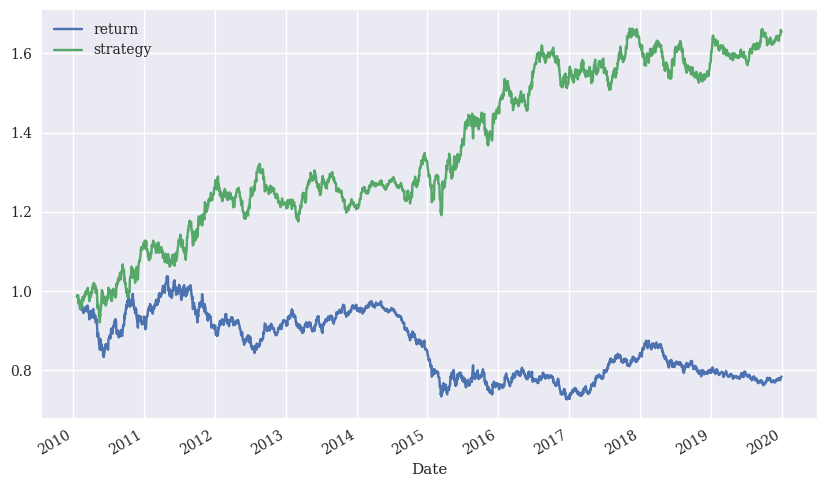

In [84]:
data[['return', 'strategy']].dropna().cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/lr_plot_6.png')

### Generalizing the Approach

In [85]:
import LRVectorBacktester as LR

In [86]:
lrbt = LR.LRVectorBacktester('EUR=', '2010-1-1', '2019-12-31',
                                     10000, 0.0)

In [87]:
lrbt.run_strategy('2010-1-1', '2019-12-31',
                  '2010-1-1', '2019-12-31', lags=5)

(17166.53, 9442.42)

In [88]:
lrbt.run_strategy('2010-1-1', '2017-12-31',
                  '2018-1-1', '2019-12-31', lags=5)

(10160.86, 791.87)

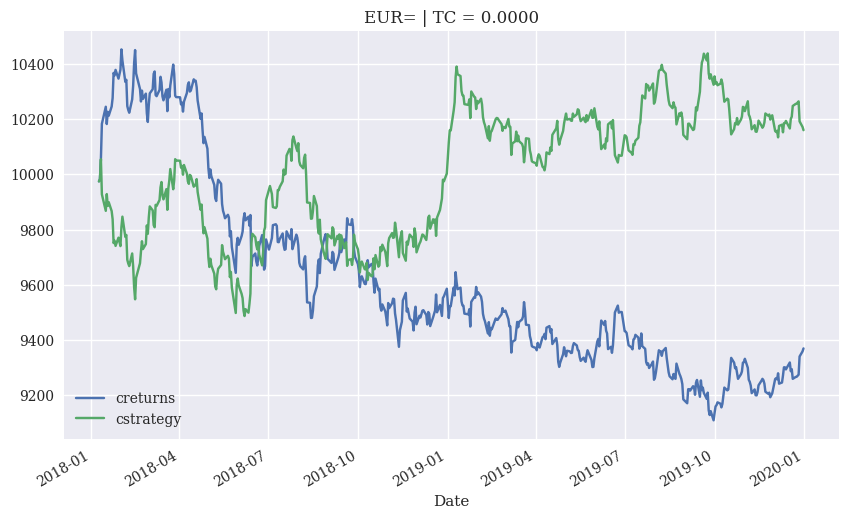

In [89]:
lrbt.plot_results()
# plt.savefig('../../images/ch05/lr_plot_7.png')

In [90]:
lrbt = LR.LRVectorBacktester('GDX', '2010-1-1', '2019-12-31',
                                     10000, 0.002)

In [91]:
lrbt.run_strategy('2010-1-1', '2019-12-31',
                  '2010-1-1', '2019-12-31', lags=7)  

(23642.32, 17649.69)

In [92]:
lrbt.run_strategy('2010-1-1', '2014-12-31',
                  '2015-1-1', '2019-12-31', lags=7)

(28513.35, 14888.41)

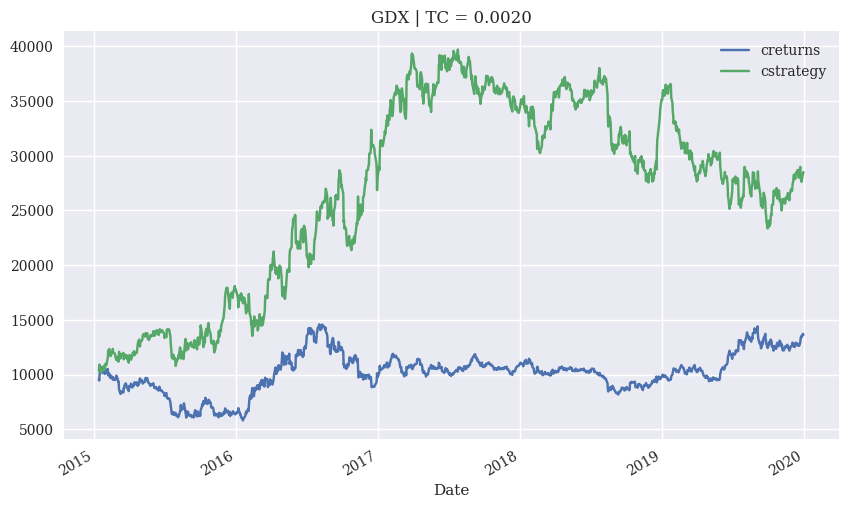

In [93]:
lrbt.plot_results()
# plt.savefig('../../images/ch05/lr_plot_8.png')

## Using Machine Learning for Market Movement Prediction

### Linear Regression with scikit-learn

In [94]:
x = np.arange(12)

In [95]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [96]:
lags = 3

In [97]:
m = np.zeros((lags + 1, len(x) - lags))

In [98]:
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]

In [99]:
from sklearn import linear_model

In [100]:
lm = linear_model.LinearRegression()

In [101]:
lm.fit(m[:lags].T, m[lags])

LinearRegression()

In [102]:
lm.coef_

array([0.33333333, 0.33333333, 0.33333333])

In [103]:
lm.intercept_

2.0

In [104]:
lm.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [105]:
lm = linear_model.LinearRegression(fit_intercept=False)

In [106]:
lm.fit(m[:lags].T, m[lags])

LinearRegression(fit_intercept=False)

In [107]:
lm.coef_

array([-0.66666667,  0.33333333,  1.33333333])

In [108]:
lm.intercept_

0.0

In [109]:
lm.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

### A Simple Classification Problem

In [110]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

In [111]:
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1])

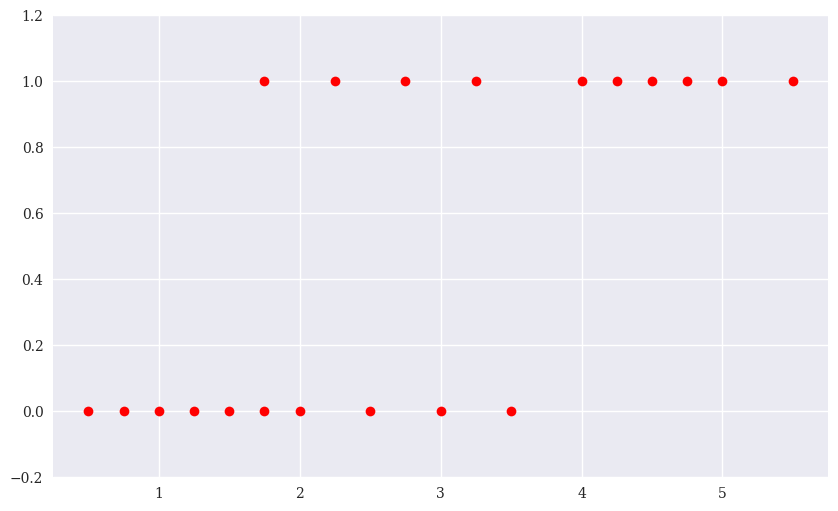

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_1.png')

In [113]:
reg = np.polyfit(hours, success, deg=1)

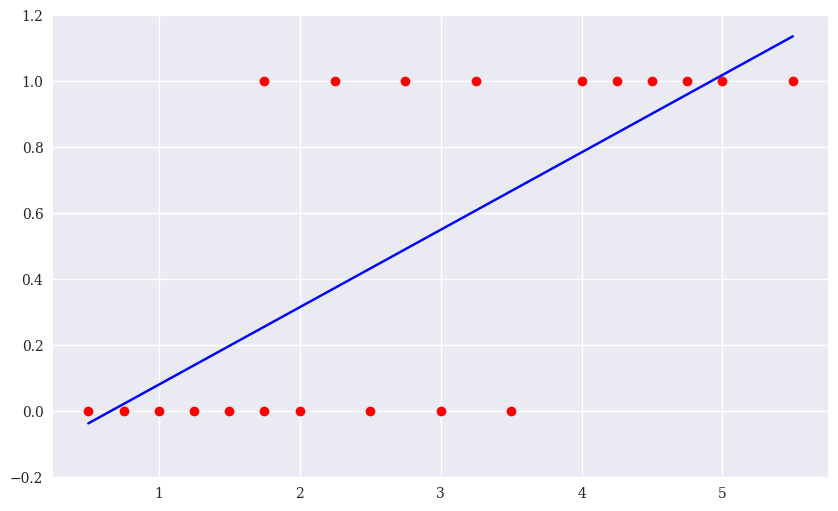

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.plot(hours, np.polyval(reg, hours), 'b')
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_2.png')

In [115]:
lm = linear_model.LogisticRegression(solver='lbfgs')

In [116]:
hrs = hours.reshape(1, -1).T

In [117]:
lm.fit(hrs, success)

LogisticRegression()

In [118]:
prediction = lm.predict(hrs)

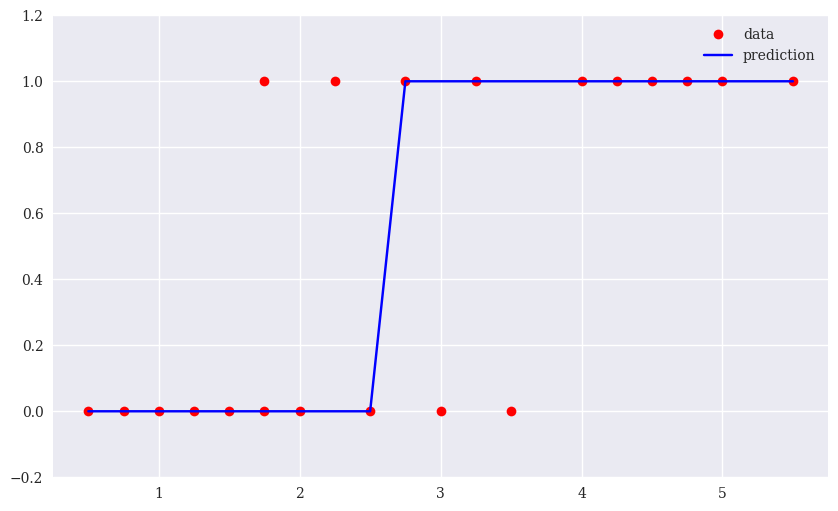

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro', label='data')
plt.plot(hours, prediction, 'b', label='prediction')
plt.legend(loc=0)
plt.ylim(-0.2, 1.2);
# plt.savefig('../../images/ch05/ml_plot_3.png')

In [120]:
prob = lm.predict_proba(hrs)

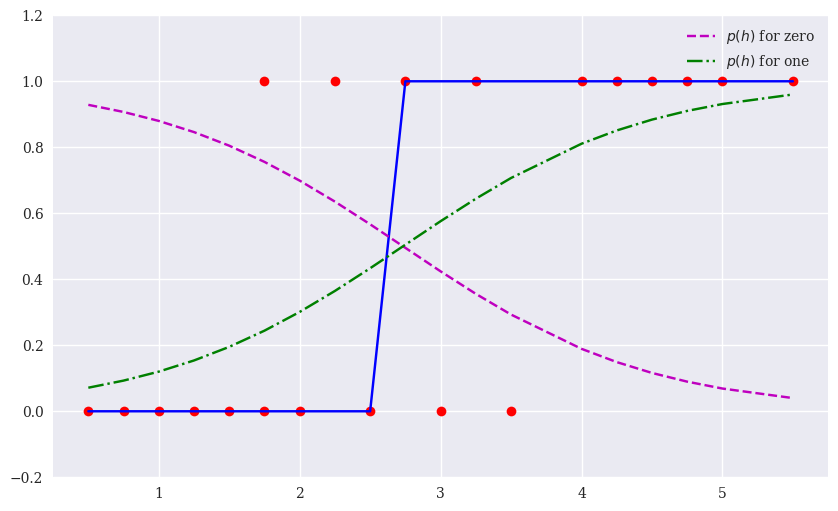

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(hours, success, 'ro')
plt.plot(hours, prediction, 'b')
plt.plot(hours, prob.T[0], 'm--',
         label='$p(h)$ for zero')
plt.plot(hours, prob.T[1], 'g-.',
         label='$p(h)$ for one')
plt.ylim(-0.2, 1.2)
plt.legend(loc=0);
# plt.savefig('../../images/ch05/ml_plot_4.png')

### Using Logistic Regression to Predict Market Direction

In [122]:
symbol = 'GLD'

In [123]:
data = pd.DataFrame(raw[symbol])

In [124]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [125]:
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [126]:
data.dropna(inplace=True)

In [127]:
lags = 3

In [128]:
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['return'].shift(lag)
    cols.append(col)

In [129]:
data.dropna(inplace=True)

In [130]:
from sklearn.metrics import accuracy_score

In [131]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)

In [132]:
lm.fit(data[cols], np.sign(data['return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [133]:
data['prediction'] = lm.predict(data[cols])

In [134]:
data['prediction'].value_counts()

 1.0    1983
-1.0     529
Name: prediction, dtype: int64

In [135]:
hits = np.sign(data['return'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()

In [136]:
hits

 1.0    1338
-1.0    1159
 0.0      12
dtype: int64

In [137]:
accuracy_score(data['prediction'],
               np.sign(data['return']))

0.5338375796178344

In [138]:
data['strategy'] = data['prediction'] * data['return']

In [139]:
data[['return', 'strategy']].sum().apply(np.exp)

return      1.289478
strategy    2.458716
dtype: float64

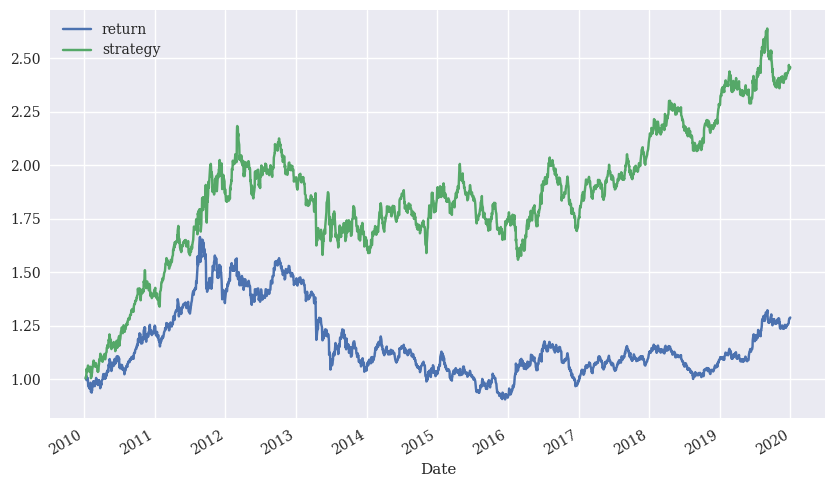

In [140]:
data[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));
# plt.savefig('../../images/ch05/ml_plot_5.png')

In [141]:
data = pd.DataFrame(raw[symbol])

In [142]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [143]:
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [144]:
lags = 5

In [145]:
cols = []
for lag in range(1, lags + 1):
    col = 'lag_%d' % lag
    data[col] = data['price'].shift(lag)
    cols.append(col)

In [146]:
data.dropna(inplace=True)

In [147]:
lm.fit(data[cols], np.sign(data['return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [148]:
data['prediction'] = lm.predict(data[cols])

In [149]:
data['prediction'].value_counts()

 1.0    2046
-1.0     465
Name: prediction, dtype: int64

In [150]:
hits = np.sign(data['return'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()

In [151]:
hits

 1.0    1332
-1.0    1162
 0.0      12
dtype: int64

In [152]:
accuracy_score(data['prediction'],
               np.sign(data['return']))

0.5316606929510155

In [153]:
data['strategy'] = data['prediction'] * data['return']

In [154]:
data[['return', 'strategy']].sum().apply(np.exp)

return      1.283110
strategy    2.623604
dtype: float64

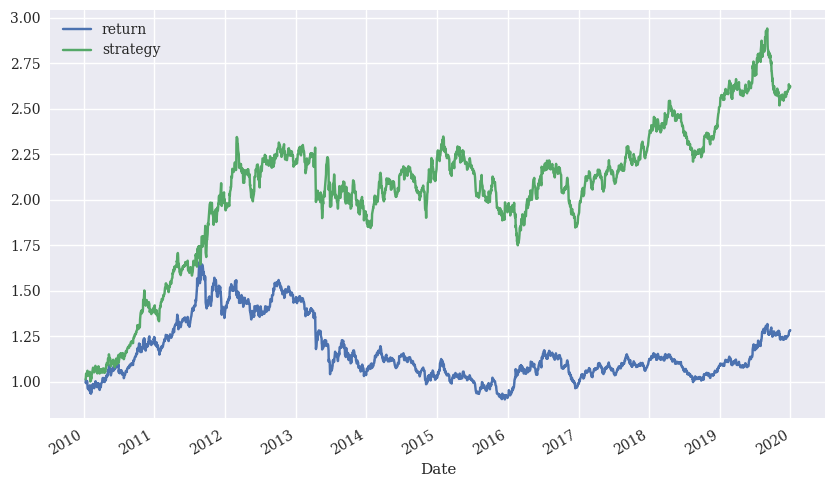

In [155]:
data[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));
# plt.savefig('../../images/ch05/ml_plot_6.png')

### Generalizing the Approach

In [156]:
import ScikitVectorBacktester as SCI

In [157]:
scibt = SCI.ScikitVectorBacktester('EUR=',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'logistic')

In [158]:
scibt.run_strategy('2015-1-1', '2019-12-31',
                   '2015-1-1', '2019-12-31', lags=15)

(12192.18, 2189.5)

In [159]:
scibt.run_strategy('2016-1-1', '2018-12-31',
                   '2019-1-1', '2019-12-31', lags=15)

(10580.54, 729.93)

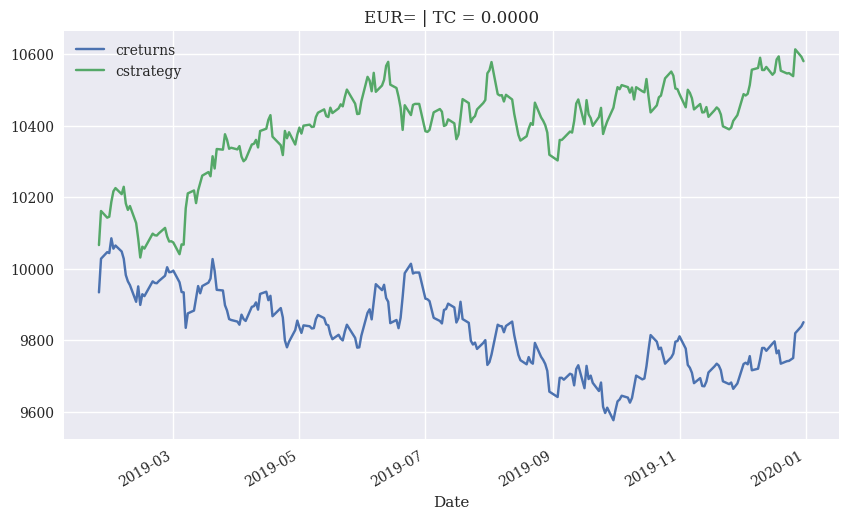

In [160]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_7.png')

In [161]:
scibt = SCI.ScikitVectorBacktester('GDX',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.00, 'logistic')

In [162]:
scibt.run_strategy('2013-1-1', '2017-12-31',
                   '2018-1-1', '2018-12-31', lags=10)

(12686.81, 4032.73)

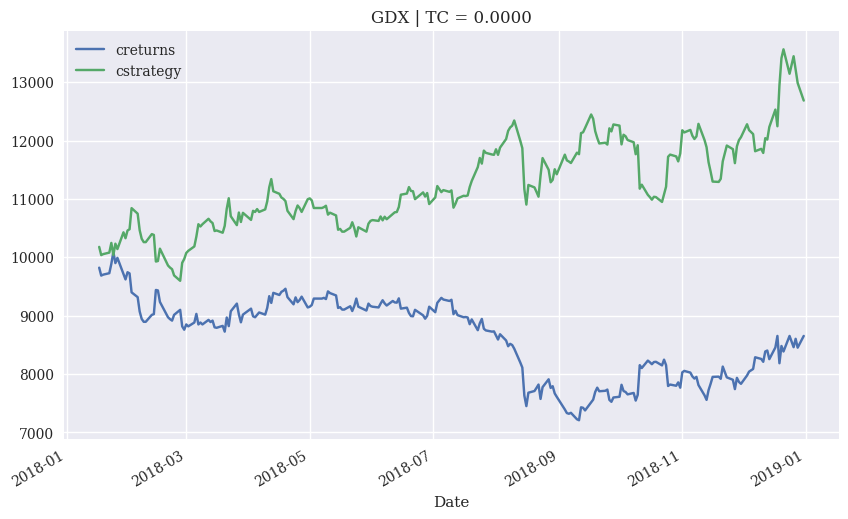

In [163]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_8.png')

In [164]:
scibt = SCI.ScikitVectorBacktester('GDX',
                                   '2010-1-1', '2019-12-31',
                                   10000, 0.0025, 'logistic')

In [165]:
scibt.run_strategy('2013-1-1', '2017-12-31',
                   '2018-1-1', '2018-12-31', lags=10)

(9588.48, 934.4)

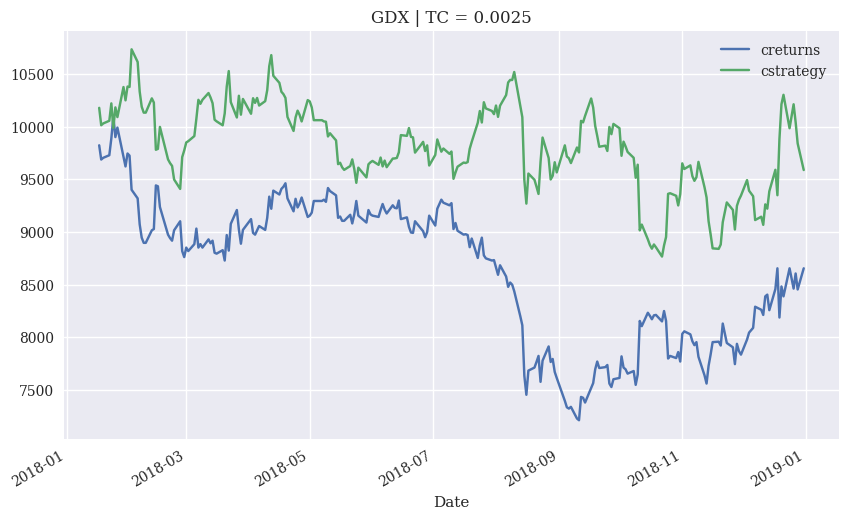

In [166]:
scibt.plot_results()
# plt.savefig('../../images/ch05/ml_plot_8_a.png')

## Using Deep Learning for Market Movement Prediction

#### The Simple Classification Problem Revisited 

In [167]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

In [168]:
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1]) 

In [169]:
data = pd.DataFrame({'hours': hours, 'success': success})

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hours    20 non-null     float64
 1   success  20 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 448.0 bytes


In [171]:
from sklearn.neural_network import MLPClassifier

In [172]:
model = MLPClassifier(hidden_layer_sizes=[32],
                     max_iter=1000, random_state=100)

In [173]:
model.fit(data['hours'].values.reshape(-1, 1), data['success'])

MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100)

In [174]:
data['prediction'] = model.predict(data['hours'].values.reshape(-1, 1)) # <2>

In [175]:
data.tail()

,hours,success,prediction
15,4.25,1,1
16,4.50,1,1
17,4.75,1,1
18,5.00,1,1
19,5.50,1,1


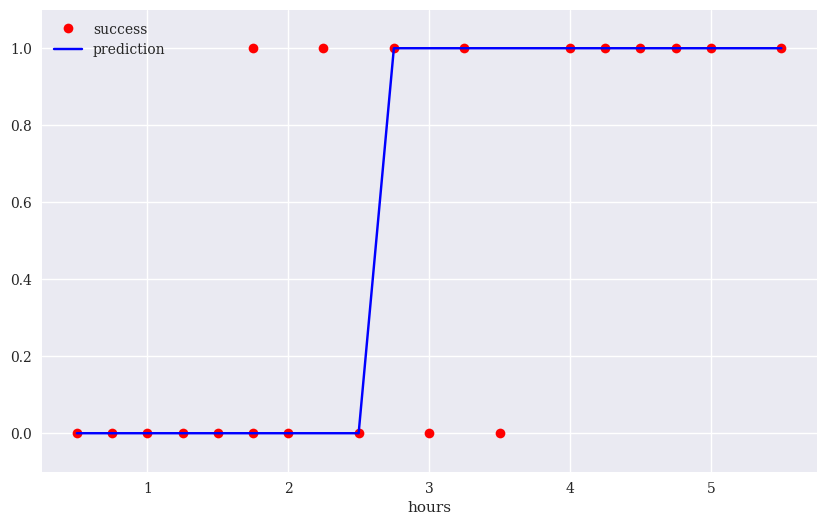

In [176]:
data.plot(x='hours', y=['success', 'prediction'],
          style=['ro', 'b-'], ylim=[-.1, 1.1],
          figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_1.png')

### Using Deep Neural Networks to Predict Market Direction

In [451]:
symbol = 'EUR='

In [452]:
data = pd.DataFrame(raw[symbol])

In [453]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [454]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1)) 

In [455]:
data['direction'] = np.where(data['return'] > 0, 1, 0)

In [456]:
lags = 5


In [457]:
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [458]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [502]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [503]:
optimizer = Adam(learning_rate=0.0001)

In [461]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [462]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # <5>
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [463]:
cutoff = '2017-12-31'

In [464]:
training_data = data[data.index < cutoff].copy()

In [465]:
mu, std = training_data.mean(), training_data.std()

In [466]:
training_data_ = (training_data - mu) / std

In [467]:
test_data = data[data.index >= cutoff].copy()

In [468]:
test_data_ = (test_data - mu) / std

In [469]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

CPU times: user 2.91 s, sys: 225 ms, total: 3.13 s
Wall time: 2.36 s


In [470]:
res = pd.DataFrame(model.history.history)

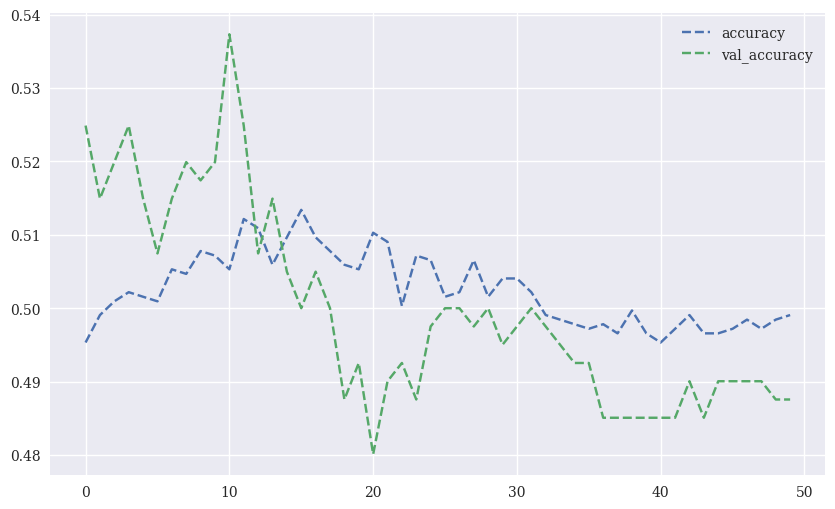

In [471]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
# plt.savefig('../../images/ch05/dnn_plot_metrics.png')

In [472]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 [==============================] - 0s 420us/step - loss: 0.8380 - accuracy: 0.5182


[0.8380064964294434, 0.5181863307952881]

In [473]:
model

In [474]:
"""
pred = model.predict(training_data_[cols])
pred = np.argmax(pred,axis=1)
"""

'\npred = model.predict(training_data_[cols])\npred = np.argmax(pred,axis=1)\n'

In [475]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

63/63 [==============================] - 0s 356us/step


In [476]:
pred[:30].flatten()

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [477]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [478]:
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

In [479]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.826569
strategy    1.074617
dtype: float64

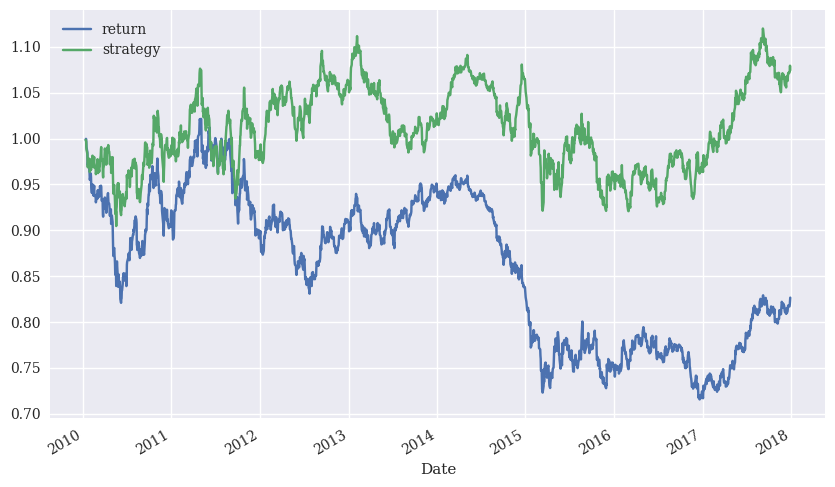

In [480]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_2.png')

In [481]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 [==============================] - 0s 528us/step - loss: 0.7943 - accuracy: 0.4553


[0.7942960858345032, 0.45526838302612305]

In [482]:
"""
pred = model.predict(test_data_[cols])
pred = np.argmax(pred,axis=1)
"""
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

16/16 [==============================] - 0s 411us/step


In [483]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [484]:
test_data['prediction'].value_counts()

 1    404
-1     99
Name: prediction, dtype: int64

In [485]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [486]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    0.875801
dtype: float64

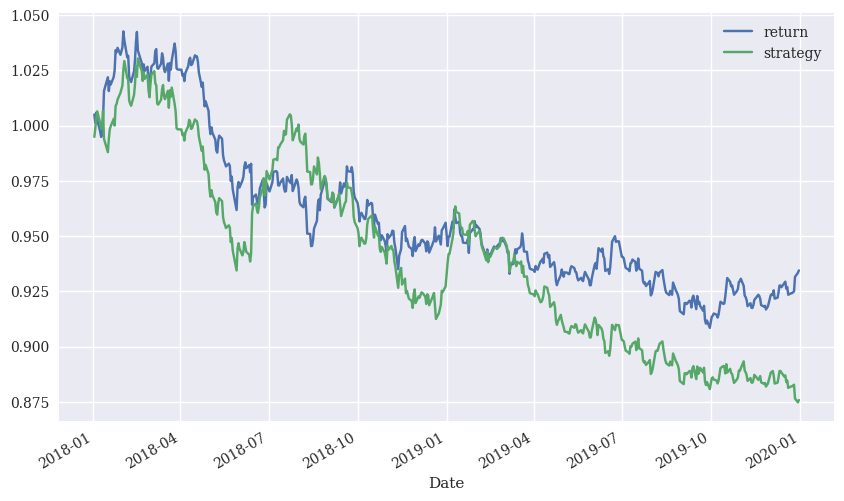

In [487]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_3.png')

### Adding Different Types of Features

In [506]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)

In [507]:
data['volatility'] = data['return'].rolling(20).std().shift(1)

In [508]:
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)

In [509]:
data.dropna(inplace=True)

In [510]:
cols.extend(['momentum', 'volatility', 'distance'])

In [511]:
print(data.round(4).tail())

             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [512]:
training_data = data[data.index < cutoff].copy()

In [513]:
mu, std = training_data.mean(), training_data.std()

In [514]:
training_data_ = (training_data - mu) / std

In [515]:
test_data = data[data.index >= cutoff].copy() 

In [516]:
test_data_ = (test_data - mu) / std

In [517]:
optimizer = Adam(learning_rate=0.0001)

In [518]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [519]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

CPU times: user 1.45 s, sys: 19.8 ms, total: 1.47 s
Wall time: 1.03 s


In [520]:
model.evaluate(training_data_[cols], training_data['direction'])

60/60 [==============================] - 0s 434us/step - loss: 0.6857 - accuracy: 0.5464


[0.6856537461280823, 0.5464079976081848]

In [522]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

60/60 [==============================] - 0s 350us/step


In [523]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [524]:
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']

In [525]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      1.001921
strategy    2.276298
dtype: float64

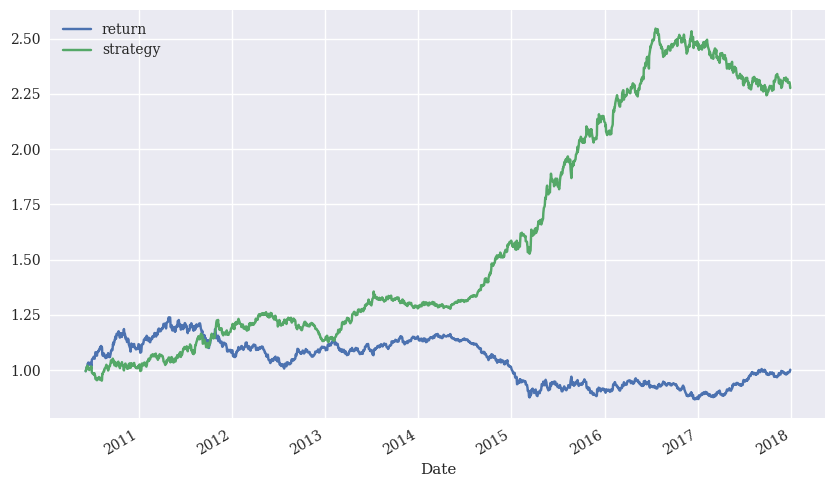

In [526]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_4.png')

In [527]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 [==============================] - 0s 477us/step - loss: 0.6947 - accuracy: 0.5209


[0.6947487592697144, 0.5208747386932373]

In [529]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

16/16 [==============================] - 0s 408us/step


In [530]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [531]:
test_data['prediction'].value_counts()

-1    338
 1    165
Name: prediction, dtype: int64

In [532]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [533]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.113456
dtype: float64

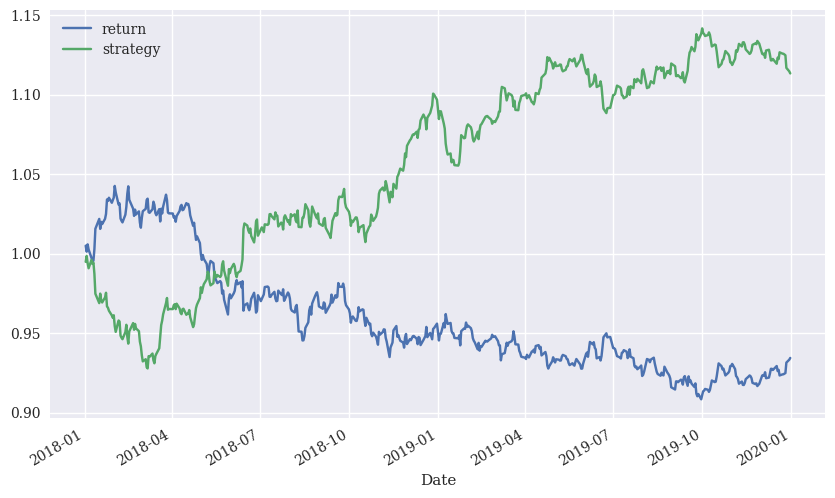

In [534]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_5.png')

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>